# 極限隨機樹(Extremely Randomized Trees)

##### 先引入我們需要的packages

In [1]:
import os 
import numpy as np
import random
from random import choices
import matplotlib.pyplot as plt
import time

# Training Data

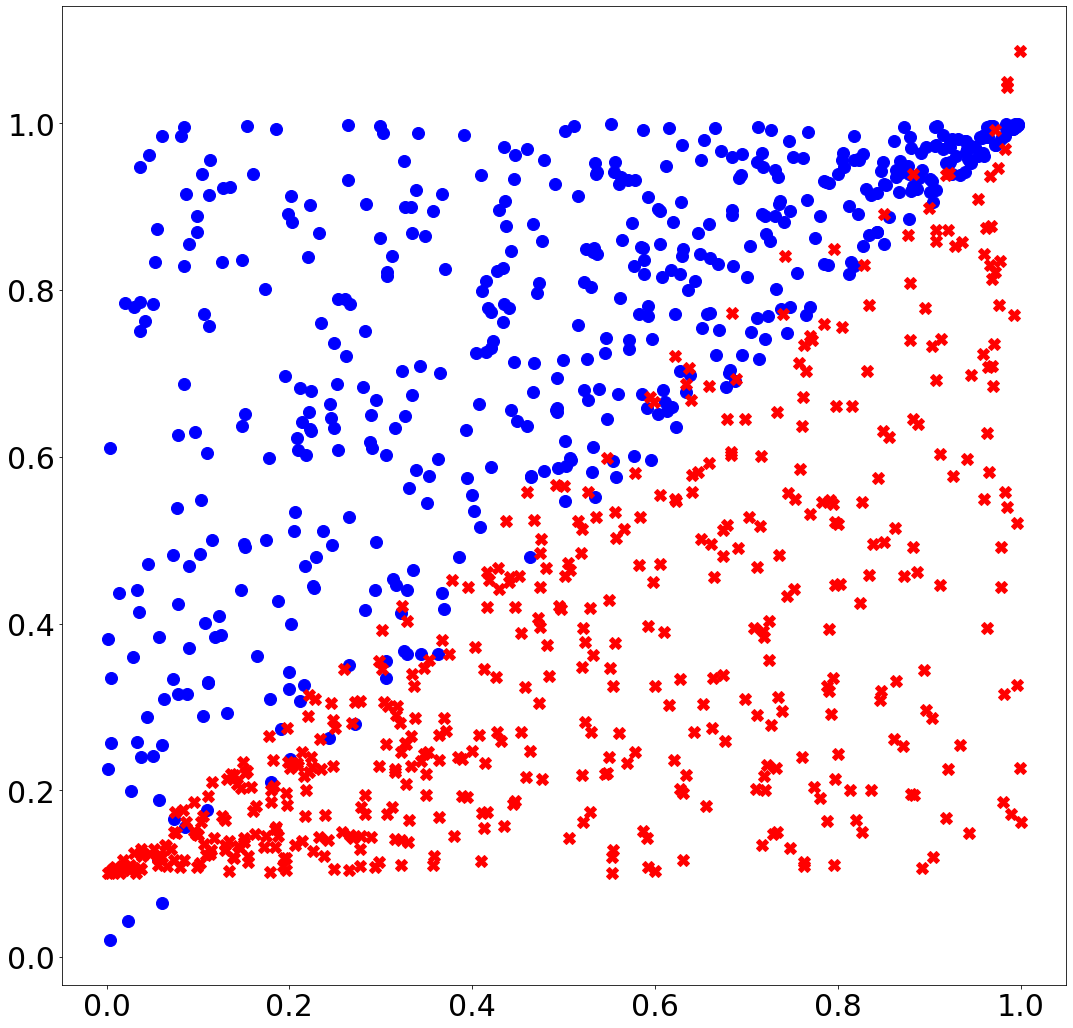

In [2]:
N=1000
x=np.zeros((N,2))
y=np.zeros(N)
for i in range(0,N): 
    f=-0.1
    if(i<N/2):
        y[i]=1
        x[i,0]=random.random()
        x[i,1]=random.uniform(x[i,0],1)
    else:
        y[i]=-1
        x[i,0]=random.random()
        x[i,1]=random.uniform(0,x[i,0])-f
plt.rcParams["figure.figsize"] = (18,18)
plt.plot(x[:500,0],x[:500,1],"bo",markersize=12)
plt.plot(x[500:,0],x[500:,1],"rX",markersize=12)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.show()

# Testing Data

In [3]:
N_test=100
x_test=np.zeros((N_test,2))
y_test=np.zeros(N_test)
for i in range(0,N_test): 
    f=-0.1
    if(i<N_test/2):
        y_test[i]=1
        x_test[i,0]=random.random()
        x_test[i,1]=random.uniform(x_test[i,0],1)
    else:
        y_test[i]=-1
        x_test[i,0]=random.random()
        x_test[i,1]=random.uniform(0,x_test[i,0])-f

# Plot Decision Line

In [4]:
def plot_line(x_split,m,x_lim,color):
    """
    m:代表第m個feature
    x_split:分割線
    xlim:畫分割線的邊界
    xlim[0,0],xlim[0,1]-->分類區橫軸最小值和最大值
    xlim[1,0],xlim[1,1]-->分類區縱軸最小值和最大值
    ################################################
    Polygon為多邊型的意思，這裡我們用x_lim的四個極值座標來劃出分類區域
    """
    if(m==0):
        polygon = plt.Polygon([[x_split,x_lim[1,0]],[x_split,x_lim[1,1]],
                              [x_lim[0,0],x_lim[1,1]],[x_lim[0,0],x_lim[1,0]],
                              [x_split,x_lim[1,0]]],fc=color[0],alpha=1)
        ax.add_patch(polygon)
        polygon = plt.Polygon([[x_split,x_lim[1,0]],[x_split,x_lim[1,1]],
                              [x_lim[0,1],x_lim[1,1]],[x_lim[0,1],x_lim[1,0]],
                              [x_split,x_lim[1,0]]],fc=color[1],alpha=1)
        ax.add_patch(polygon)
    else:
        polygon = plt.Polygon([[x_lim[0,0],x_split],[x_lim[0,1],x_split],
                              [x_lim[0,1],x_lim[1,1]],[x_lim[0,0],x_lim[1,1]],
                               [x_lim[0,0],x_split]],fc=color[1],alpha=1)
        ax.add_patch(polygon)
        polygon = plt.Polygon([[x_lim[0,0],x_split],[x_lim[0,1],x_split],
                              [x_lim[0,1],x_lim[1,0]],[x_lim[0,0],x_lim[1,0]],
                               [x_lim[0,0],x_split]],fc=color[0],alpha=1)
        ax.add_patch(polygon)

# Gini Index

In [5]:
def Gini(s,y,K):
    """
    這個方程式對應到Gini_index
    s:subtree裡面所有的index
    K:種類樹木
    """
    return 1-((sum(y[s]==1)/len(s))**2+(sum(y[s]==-1)/len(s))**2)

# Decision Stump

In [6]:
def Decision_Stump(x,y,K):
    """
    impurity_x0: 用來放橫軸特徵的impurity候選值
    impurity_x1: 用來放縱軸特徵的impurity候選值
    x0_sort: 所有資料點橫軸座標排序
    x1_sort: 所有資料點縱軸座標排序
    x0_sort_index:所有資料點橫軸座標排序後所對應的index
    x1_sort_index:所有資料點縱軸座標排序後所對應的index
    """
    impurity_x0=np.zeros(len(y)-1)
    impurity_x1=np.zeros(len(y)-1)
    
    x0_sort=np.sort(x[:,0])
    x1_sort=np.sort(x[:,1])
    
    x0_sort_index=np.argsort(x[:,0])
    x1_sort_index=np.argsort(x[:,1])
    """
    這裡的演算法核心就是我們以排列好的橫軸和縱標
    從第一個資料開始分成兩半，然後並計算impurity值
    -->迴圈執行步驟
    1. 以橫軸的feature分成兩個subtree
    2. 計算對應的橫軸impirity值
    3. 以縱軸的feature分成兩個subtree
    4. 計算對應的縱軸impirity值
    """
    for i in range(1,len(y)):
        s_left,s_right=x0_sort_index[:i],x0_sort_index[i:]
        impurity_x0[i-1]=(len(s_left)/len(y))*Gini(s_left,y,K)+(len(s_right)/len(y))*Gini(s_right,y,K)
        s_left,s_right=x1_sort_index[:i],x1_sort_index[i:]
        impurity_x1[i-1]=(len(s_left)/len(y))*Gini(s_left,y,K)+(len(s_right)/len(y))*Gini(s_right,y,K)
    """
    比較橫軸和縱軸最小的impurity值，如果其中一個比較小就回傳切割線座標
    """
    if(min(impurity_x0)<min(impurity_x1)):
        x_split=(x0_sort[np.argmin(impurity_x0)]+x0_sort[np.argmin(impurity_x0)+1])/2
        return x_split,0,min(impurity_x0)
    else:
        x_split=(x1_sort[np.argmin(impurity_x1)]+x1_sort[np.argmin(impurity_x1)+1])/2
        return x_split,1,min(impurity_x1)

# Extra Tree Decision Stump

In [7]:
def Extra_Decision_Stump(x,y,K):
    """
    num代表我們隨機挑選分割線的數目
    而我們一開使會隨機產生num個只為0或1的數字並存入seed_feature
    其中這裡的0代表第一欄feature，1代表第二欄feature
    而會建立一個seed_split矩陣
    如果seed_feature=0，我們就從第一欄feature的最小到最大值之間隨機產生一個數字
    如果seed_feature=1，我們就從第二欄feature的最小到最大值之間隨機產生一個數字
    而之後我們就把這num個候選值，去計算他們的impurity值，然後挑選出一個最佳解並回傳
    """
    num=300
    seed_feature=np.array(choices(range(0,len(x[0,:])), k=num))
    seed_split=np.zeros(num)
    seed_split[seed_feature==0]=np.random.uniform(min(x[:,0]),max(x[:,0]),sum(seed_feature==0))
    seed_split[seed_feature==1]=np.random.uniform(min(x[:,1]),max(x[:,1]),sum(seed_feature==1))
    impurity=np.zeros(num)
    for i in range(0,num):
        BOOL=x[:,seed_feature[i]]<seed_split[i]
        s_left,s_right=np.array(np.where(BOOL)).flatten(),np.array(np.where(~BOOL)).flatten()
        impurity[i]=(len(s_left)/len(y))*Gini(s_left,y,K)+(len(s_right)/len(y))*Gini(s_right,y,K)
    return seed_split[np.argmin(impurity)],seed_feature[np.argmin(impurity)],min(impurity)

# Decision Tree Algorithms

In [8]:
def Decision_Tree(x,y,x_real,y_real,x_test,y_test,index,index_test,max_depth,x_lim,K,y_train,y_pred,typ):
    """
    x: 輸入訓練資料(數量隨樹的深度改變)
    y: 輸出訓練資料(數量隨樹的深度改變)
    x_real: 輸入訓練資料
    y_real: 輸出訓練資料
    x_test: 輸入測試資料
    y_test: 輸出測試資料
    index: 當前輸入到決策樹演算法中的訓練資料編號
    index_test: 當前輸入到決策樹演算法中的測試資料編號
    max_depth: 最大決策樹深度
    x_lim: 用來畫分割區域的座標
    K: 輸出資料的類別數目
    y_train: 於訓練集所預測的輸出值
    y_pred: 於測試集所預測的輸出值
    type:0的話呼叫一般的Decision Stump，1的話呼叫Extra Tree的Decision Stum
    """
    """
    執行Decision Stump演算法算出最佳分割線
    得到第m特徵的分割線座標x_split後
    以x_split和m將訓練Decision Tree的訓練資料(隨機選取的)分成left和right兩部分
    """
    if(typ==0):
        x_split,m,impurity=Decision_Stump(x,y,K)
    else:
        x_split,m,impurity=Extra_Decision_Stump(x,y,K)
    p=x[:,m]<x_split
    x_left,y_left=x[p],y[p]
    x_right,y_right=x[~p],y[~p]
    """
    接著我們一樣以x_split和m，拆分我們的真實訓練資料和測試資料，所以這裡
    left_index和right_index分別代表在此Node的之下
    真實訓練資料分到左邊subtree的index和分到右邊subtree的index
    left_index_test和right_index_test分別代表在此Node的之下
    測試資料分到左邊subtree的index和分到右邊subtree的index
    """
    p_real=(x_real[:,m]<x_split).flatten()
    p_real_left=np.where(p_real)
    p_real_right=np.where(~p_real)
    left_index=np.intersect1d(p_real_left,index)
    right_index=np.intersect1d(p_real_right,index)
    p_test=(x_test[:,m]<x_split).flatten()
    p_test_left=np.where(p_test)
    p_test_right=np.where(~p_test)
    left_index_test=np.intersect1d(p_test_left,index_test)
    right_index_test=np.intersect1d(p_test_right,index_test)
    """
    而在這邊我們設定分類區域的背景顏色，然後劃出我們的分割區域
    畫完之後就重新更新我們左邊和右邊subtree的區域邊界x_lim_left和x_lim_right
    """
    if(sum(y_left==1)/len(y_left)>sum(y_right==1)/len(y_right)):
        color=["#7777FF","#FF7777"]
    elif(sum(y_left==1)/len(y_left)<sum(y_right==1)/len(y_right)):
        color=["#FF7777","#7777FF"]
    else:
        if(sum(y_left==-1)/len(y_left)>sum(y_right==-1)/len(y_right)):
            color=["#FF7777","#7777FF"]
        else:
            color=["#7777FF","#FF7777"]
    plot_line(x_split,m,x_lim,color)
    x_lim_left,x_lim_right=np.zeros((2,2)),np.zeros((2,2))
    if(m==0):
        x_lim_left[0,0],x_lim_left[0,1],x_lim_left[1,0],x_lim_left[1,1]=x_lim[0,0],x_split,x_lim[1,0],x_lim[1,1]
        x_lim_right[0,0],x_lim_right[0,1],x_lim_right[1,0],x_lim_right[1,1]=x_split,x_lim[0,1],x_lim[1,0],x_lim[1,1]
    else:
        x_lim_left[0,0],x_lim_left[0,1],x_lim_left[1,0],x_lim_left[1,1]=x_lim[0,0],x_lim[0,1],x_lim[1,0],x_split
        x_lim_right[0,0],x_lim_right[0,1],x_lim_right[1,0],x_lim_right[1,1]=x_lim[0,0],x_lim[0,1],x_split,x_lim[1,1]
    """
    更新完我們的區域邊界後，接下來就是檢查我們左邊和右邊的subtree
    他們是否已經分類完成，底下的類別全部相同。所以如果
    左邊的subtree分類完成check_left=True
    右邊的subtree分類完成check_right=True
    """
    check_left=True
    for i in range(0,len(y_left)):
        if(y_left[0]!=y_left[i]):
            check_left=False
            break
    check_right=True
    for i in range(0,len(y_right)):
        if(y_right[0]!=y_right[i]):
            check_right=False
            break
    """
    最後就是設定Decision Tree的停止條件
    1. impirity=0 / 2. 達到最大深度 / 3.左右兩邊subtree都完美分類好
    而這裡我們可以分成四個case
    (1) 達到Decision Tree停止條件
       --> 我們檢查左右兩邊Decision tree把他分成什麼類別後
           我們就將y_train和y_pred標註Decision Tree預測的類別，最後並回傳
    (2) 左邊的subtree分類完成，但是右邊的subtree還沒分好
       --> 我們檢查左邊的subtree的類別
           然後將左邊subtree的y_train和y_pred，標註Decision Tree所預測的類別
           接著將右邊subtree的資料帶入Decision Tree演算法繼續分類，最後並回傳
    (3) 右邊的subtree分類完成，但是左邊的subtree還沒分好
       --> 我們檢查右邊的subtree的類別
           然後將右邊subtree的y_train和y_pred，標註Decision Tree所預測的類別
           接著將左邊subtree的資料帶入Decision Tree演算法繼續分類，最後並回傳
    (4) 左右兩邊都沒有分好
       --> 將左邊和右邊的subtree都丟到Decision Tree演算法繼續分類，最後並回傳
    """
    if((impurity==0)or(max_depth==1)or((check_left)and(check_right))):
        if(sum(y_left==1)/len(y_left)>sum(y_right==1)/len(y_right)):
            label_left,label_right=1,-1
        elif(sum(y_left==1)/len(y_left)<sum(y_right==1)/len(y_right)):
            label_left,label_right=-1,1
        else:
            if(sum(y_left==-1)/len(y_left)>sum(y_right==-1)/len(y_right)):
                label_left,label_right=-1,1
            else:
                label_left,label_right=1,-1
        y_train[left_index],y_train[right_index]=label_left,label_right
        y_pred[left_index_test],y_pred[right_index_test]=label_left,label_right
        return y_train,y_pred
    elif(check_left):
        max_depth-=1
        y_train[left_index]=y_left[0]
        y_pred[left_index_test]=y_left[0]
        y_train,y_pred=Decision_Tree(x_right,y_right,x_real,y_real,x_test,y_test,
                                     right_index,right_index_test,max_depth,x_lim_right,
                                     K,y_train,y_pred,typ)
        return y_train,y_pred
    elif(check_right):
        max_depth-=1
        y_train[right_index]=y_right[0]
        y_pred[right_index_test]=y_right[0]
        y_train,y_pred=Decision_Tree(x_left,y_left,x_real,y_real,x_test,y_test,
                                     left_index,left_index_test,max_depth,x_lim_left,
                                     K,y_train,y_pred,typ)
        return y_train,y_pred
    else:
        max_depth-=1
        y_train,y_pred=Decision_Tree(x_left,y_left,x_real,y_real,x_test,y_test,
                                     left_index,left_index_test,max_depth,x_lim_left,
                                     K,y_train,y_pred,typ)
        y_train,y_pred=Decision_Tree(x_right,y_right,x_real,y_real,x_test,y_test,
                                     right_index,right_index_test,max_depth,x_lim_right,
                                     K,y_train,y_pred,typ)
        return y_train,y_pred

# Extremely Randomized Trees

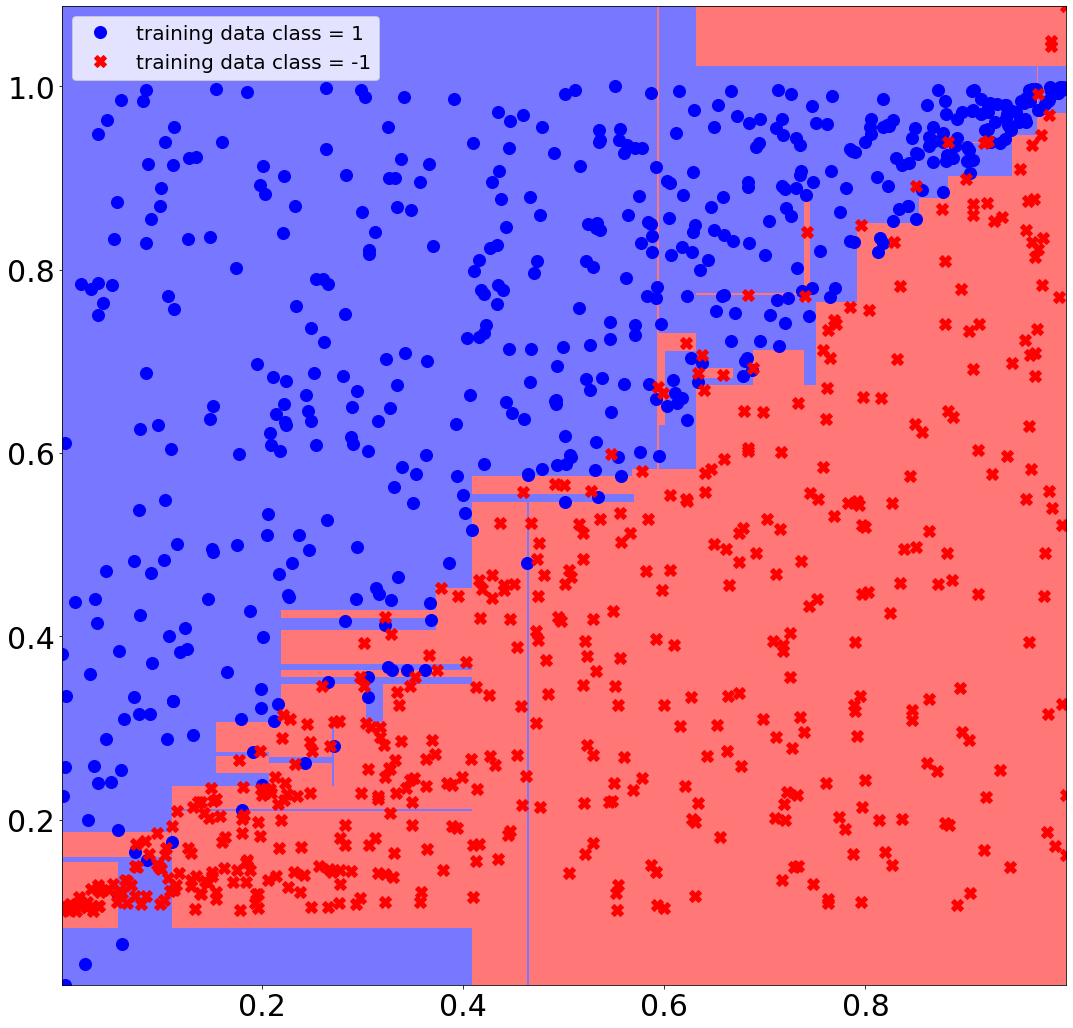

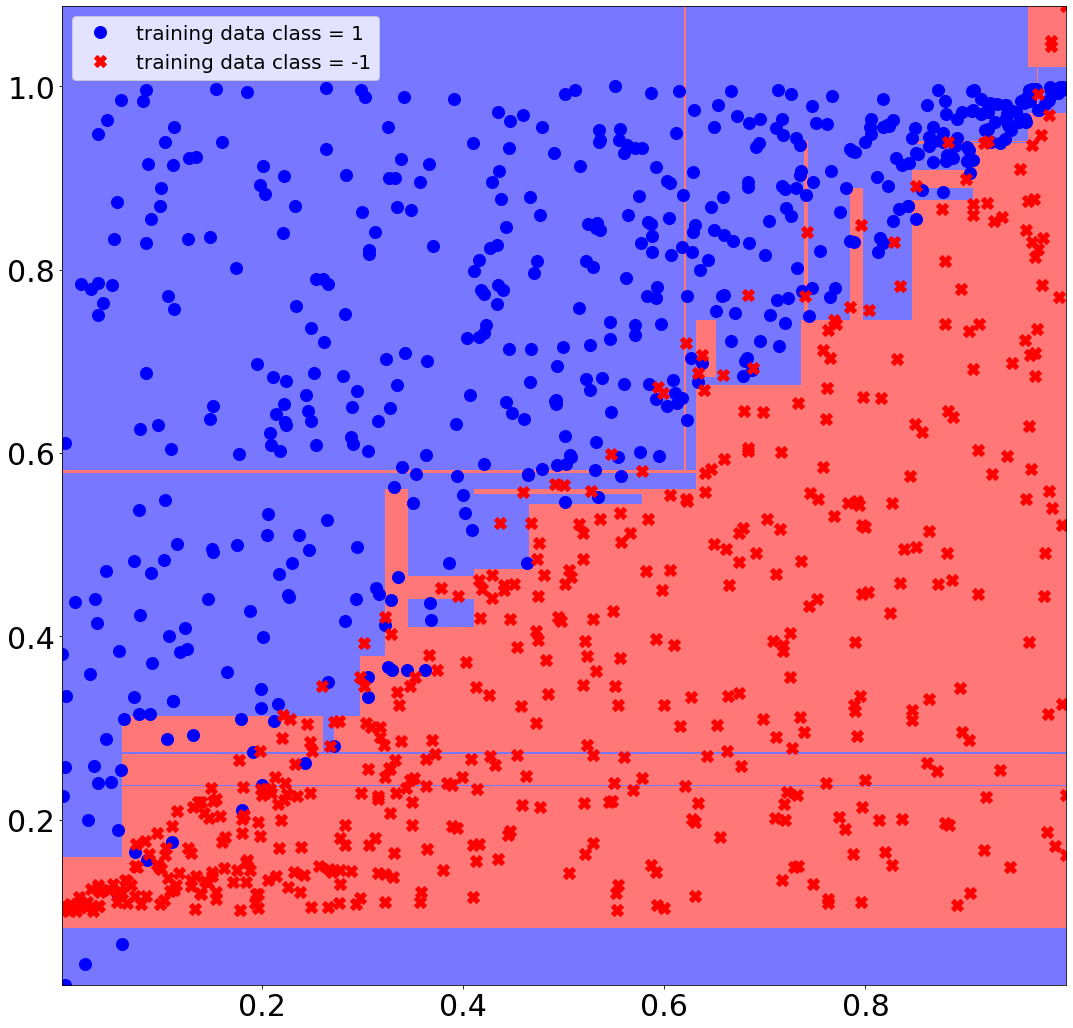

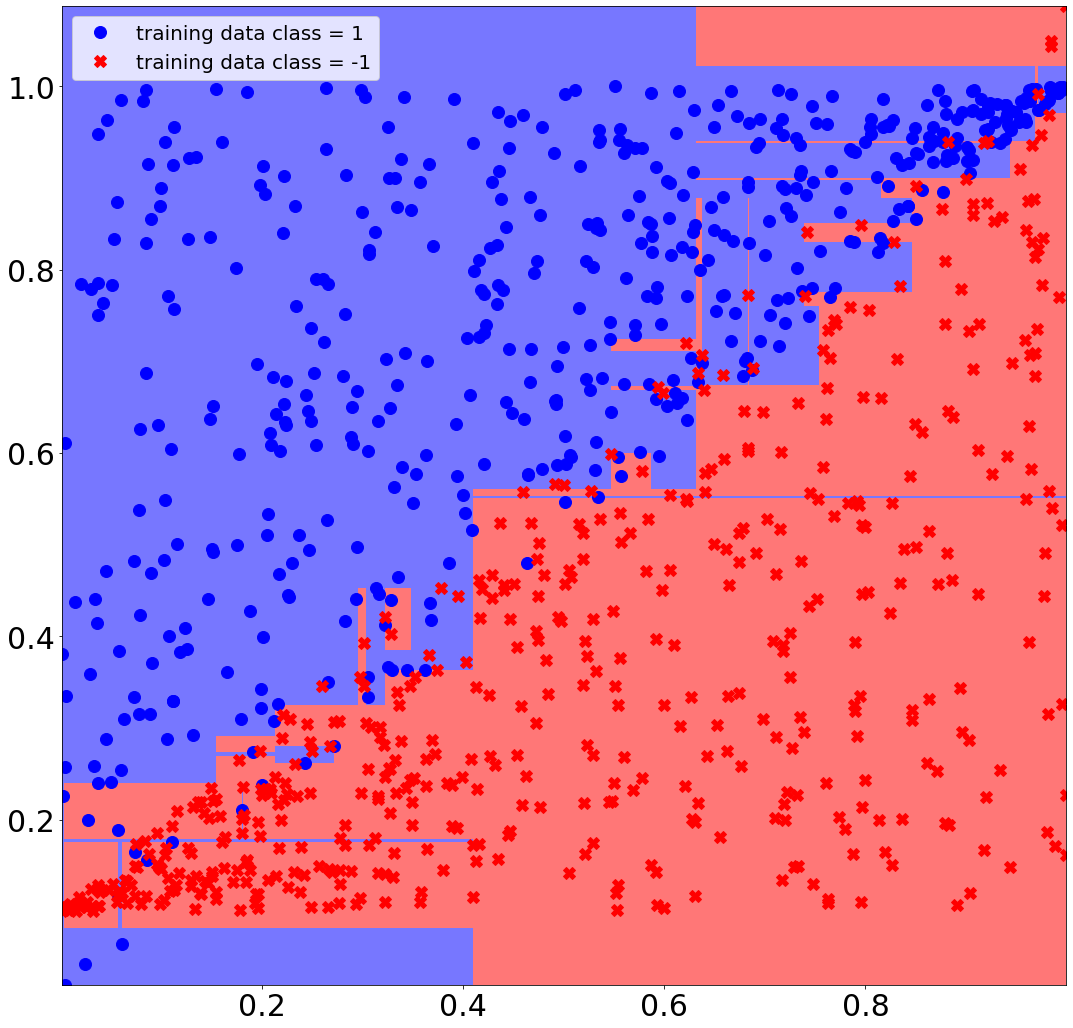

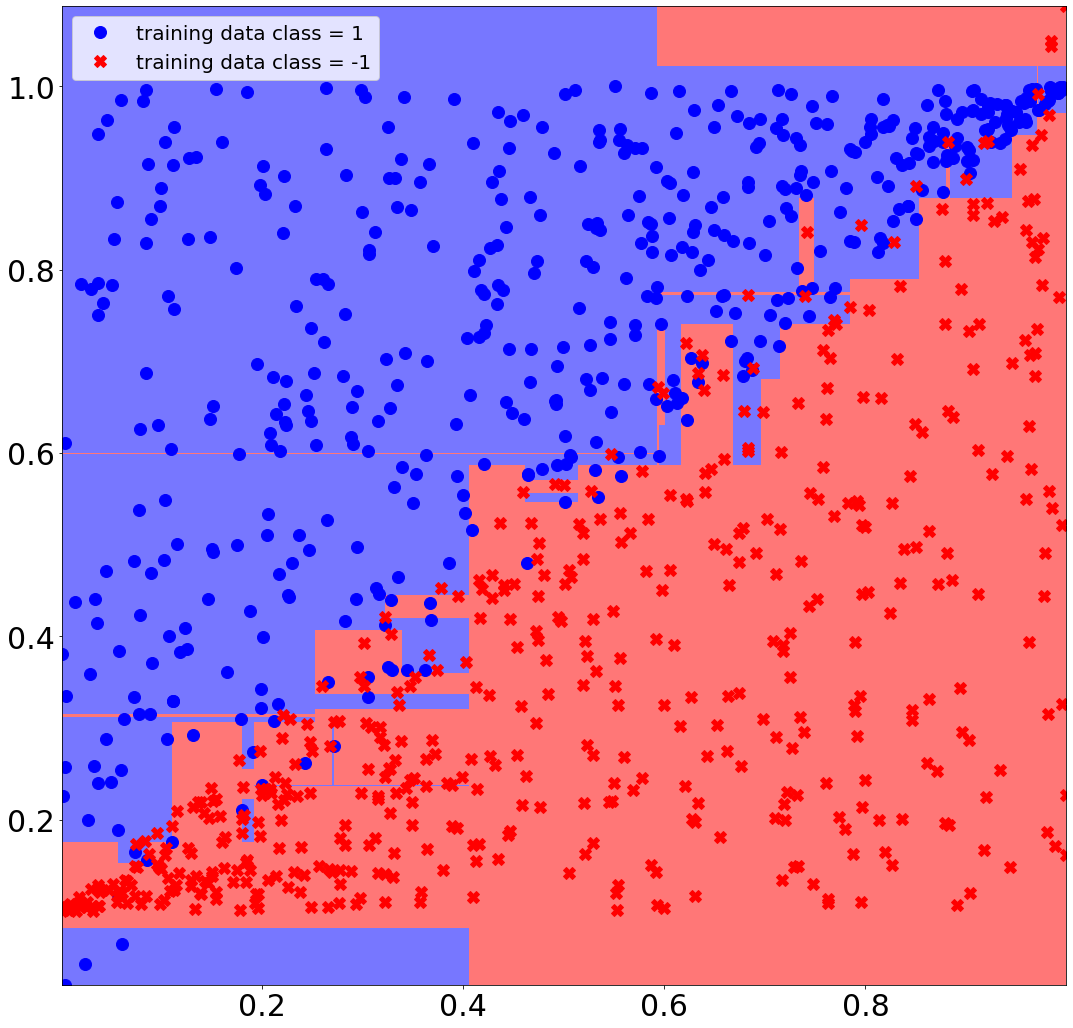

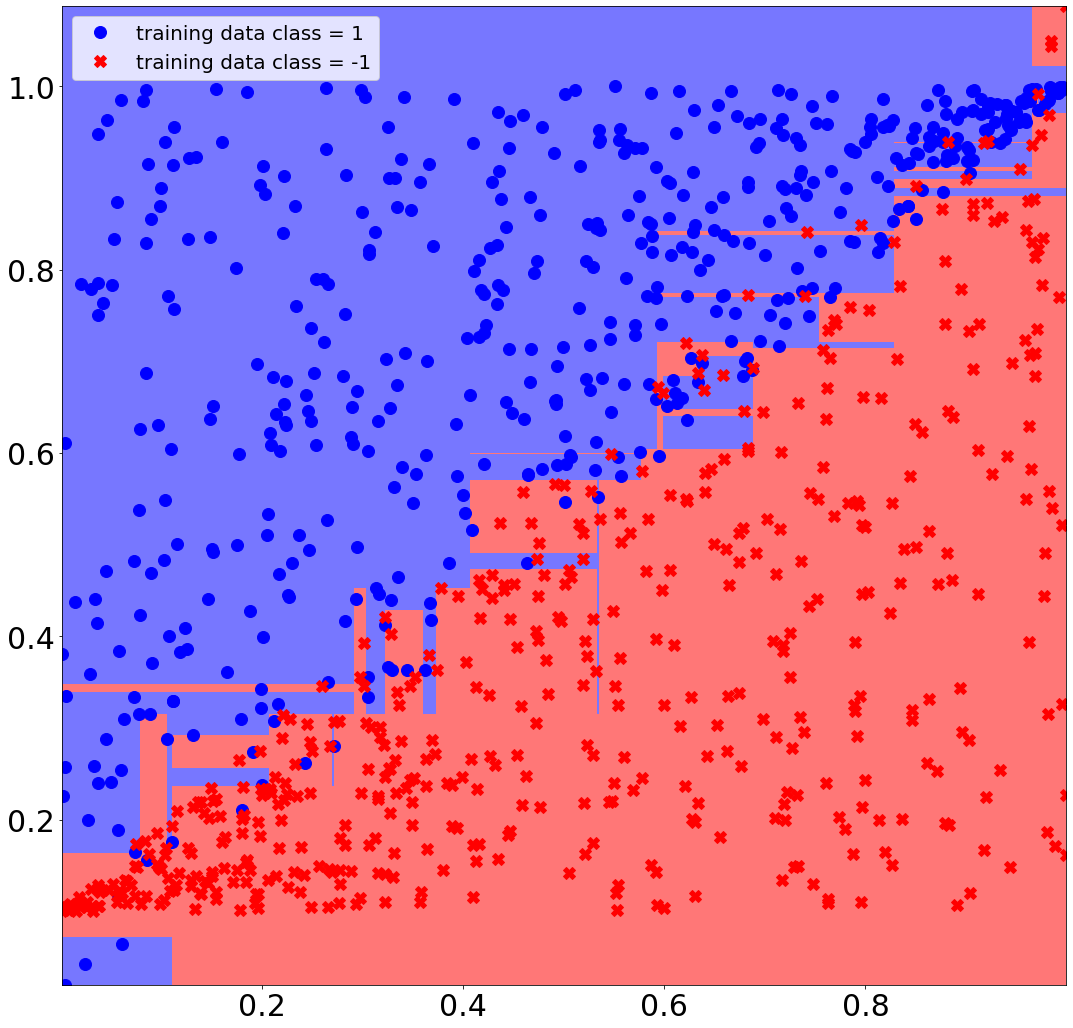

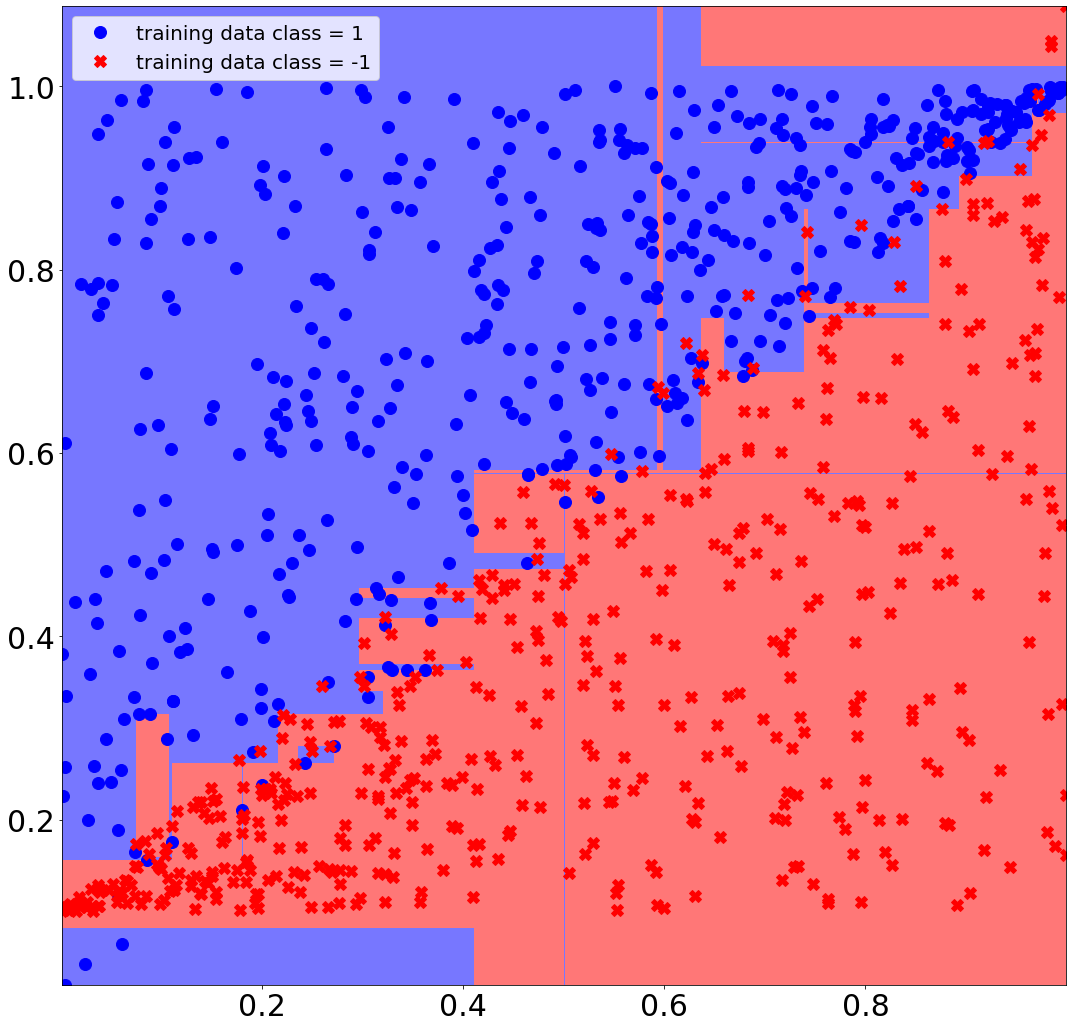

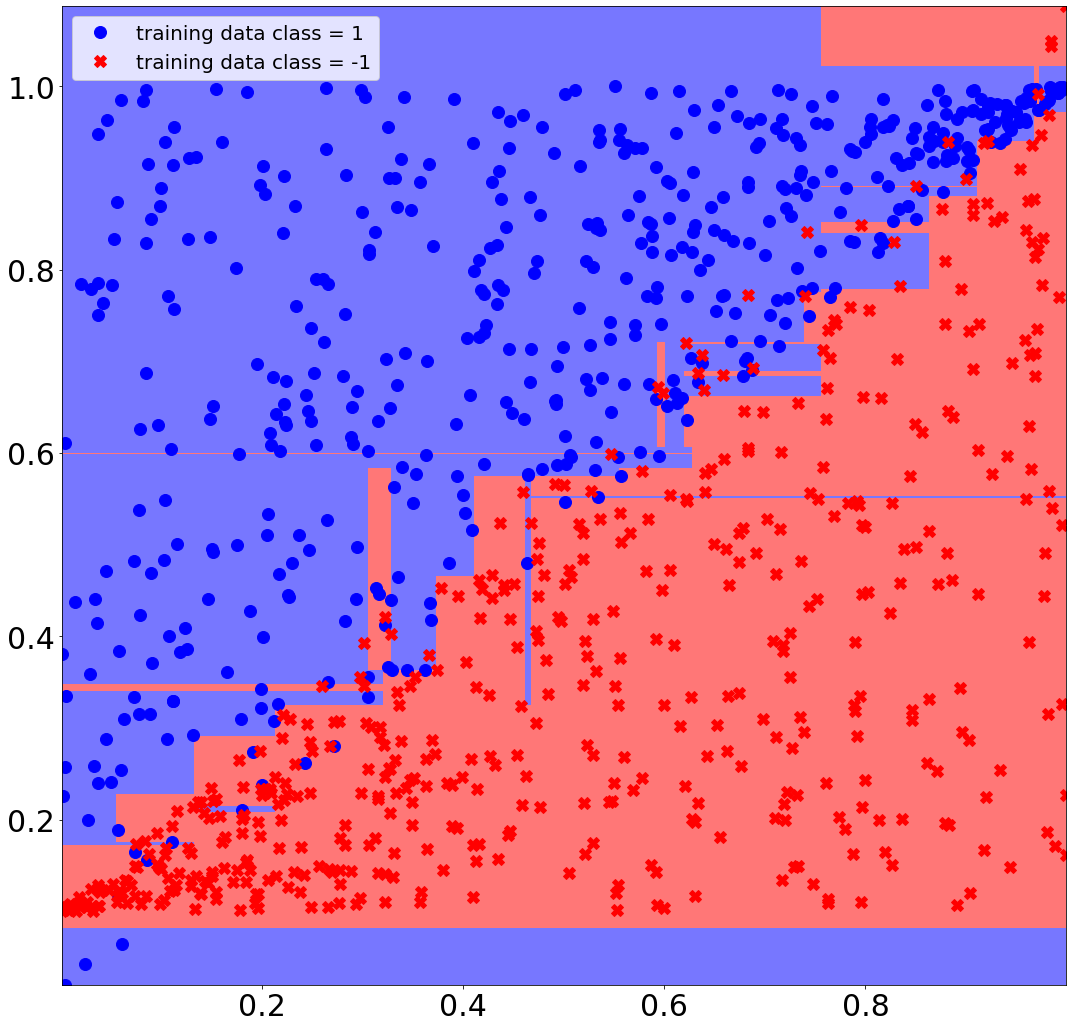

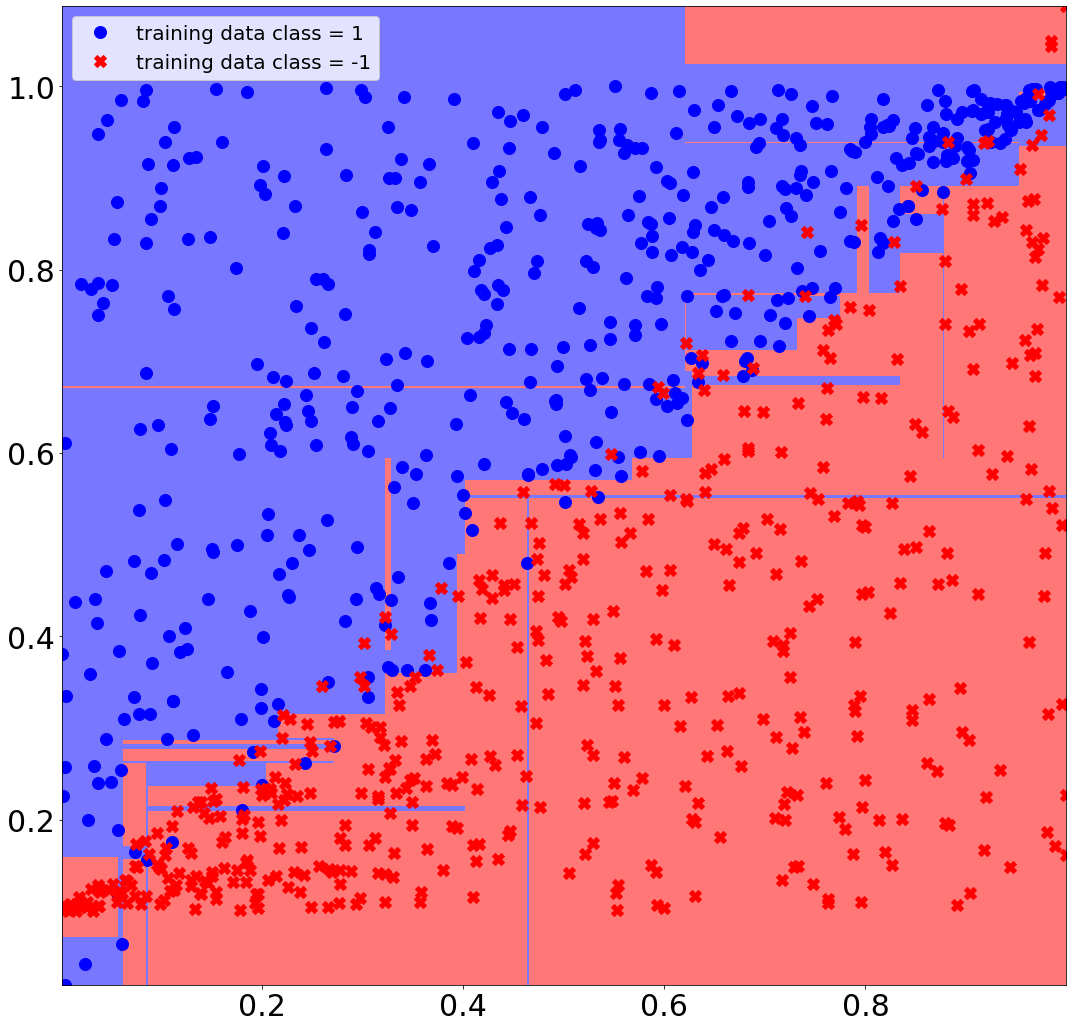

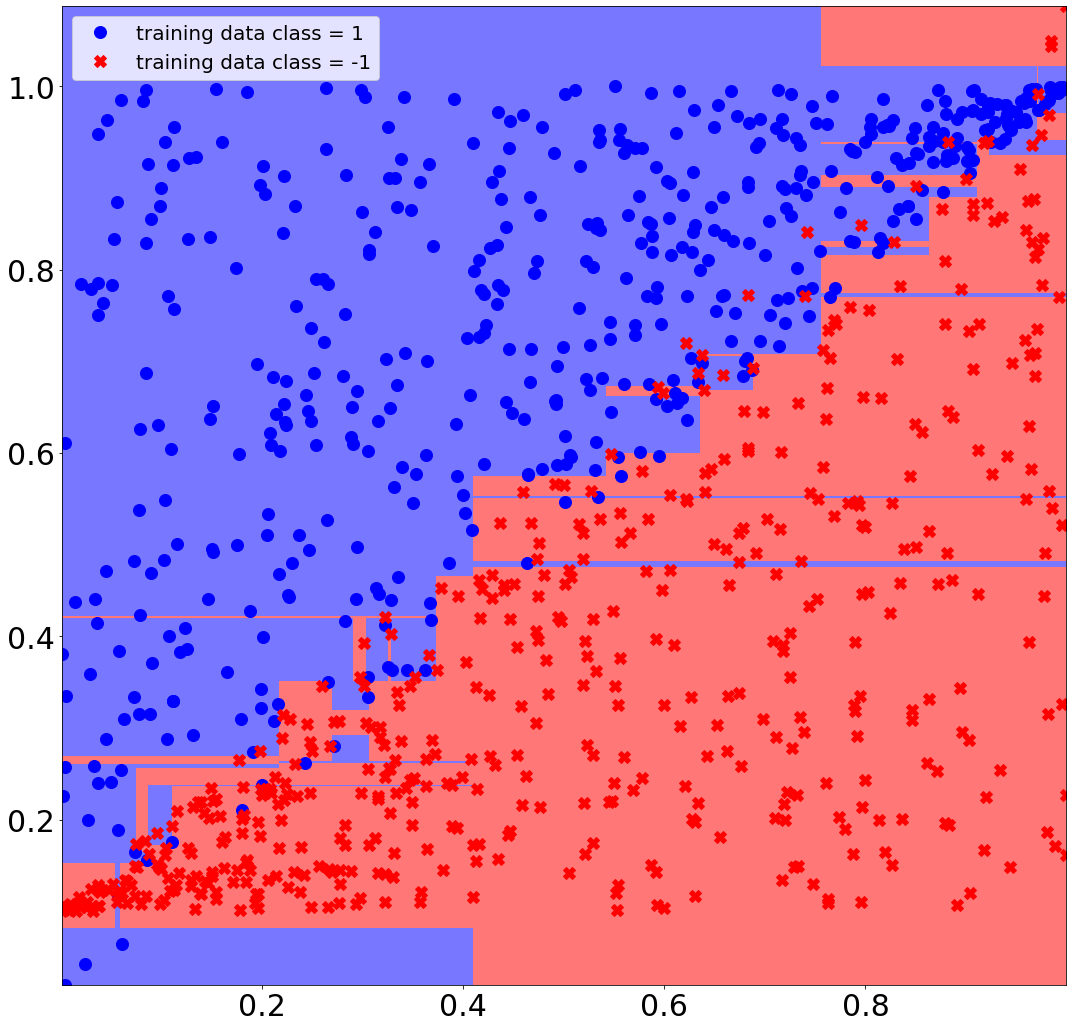

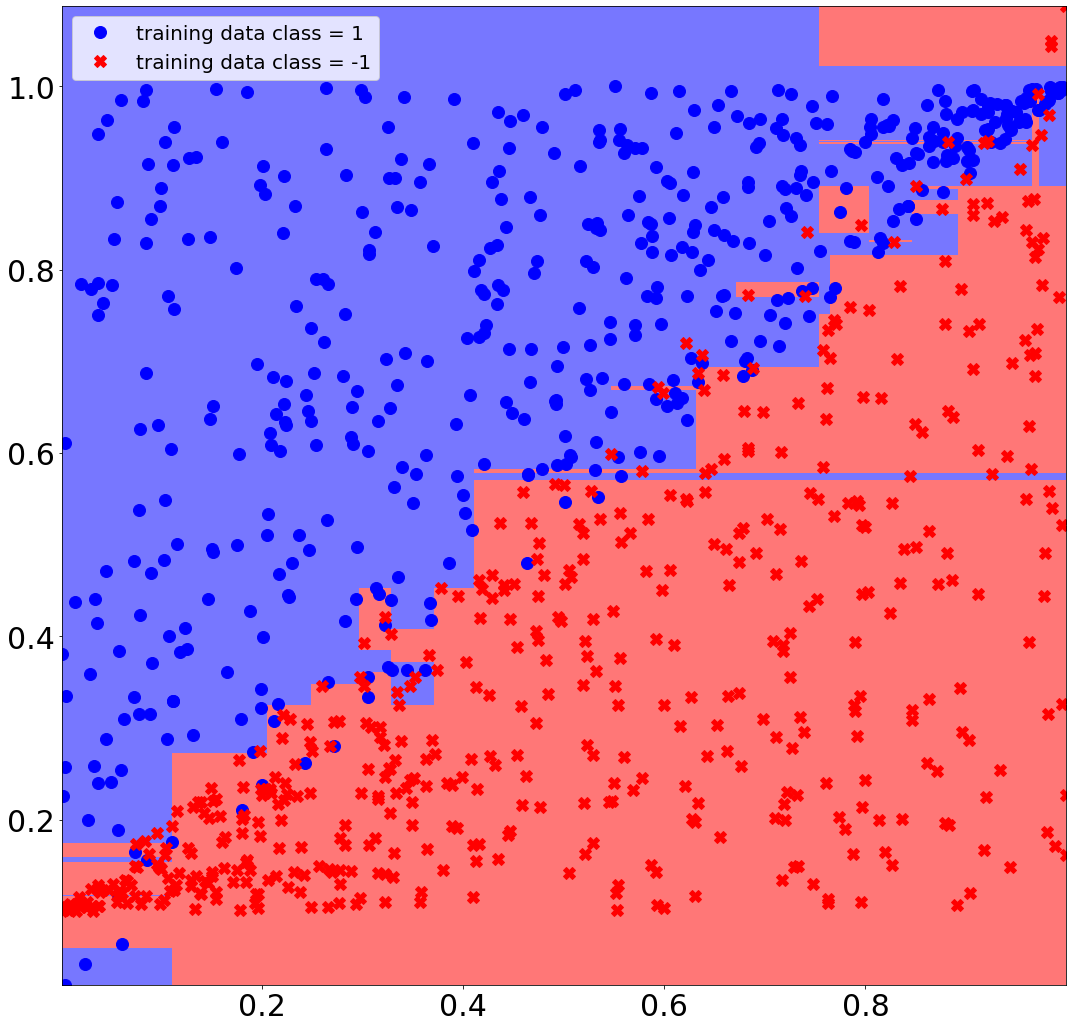

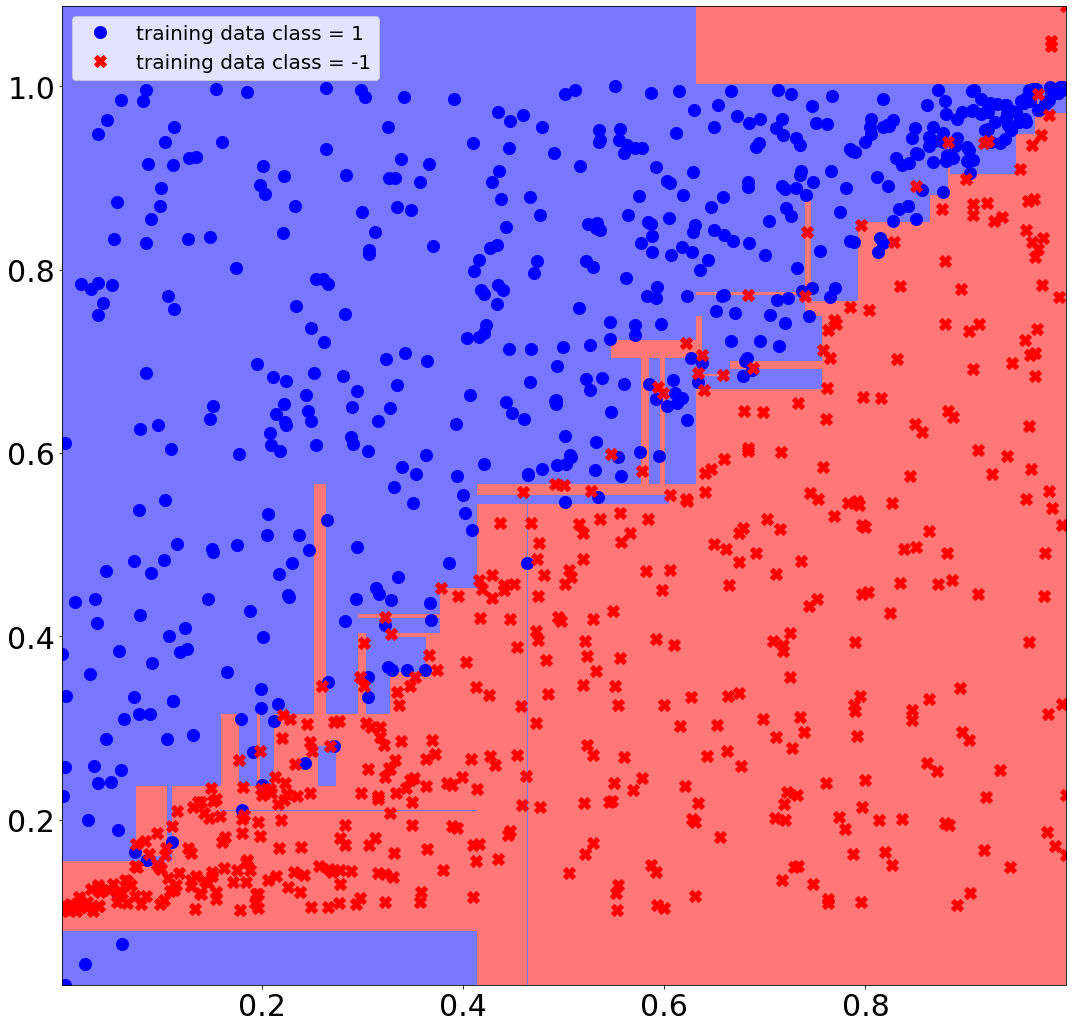

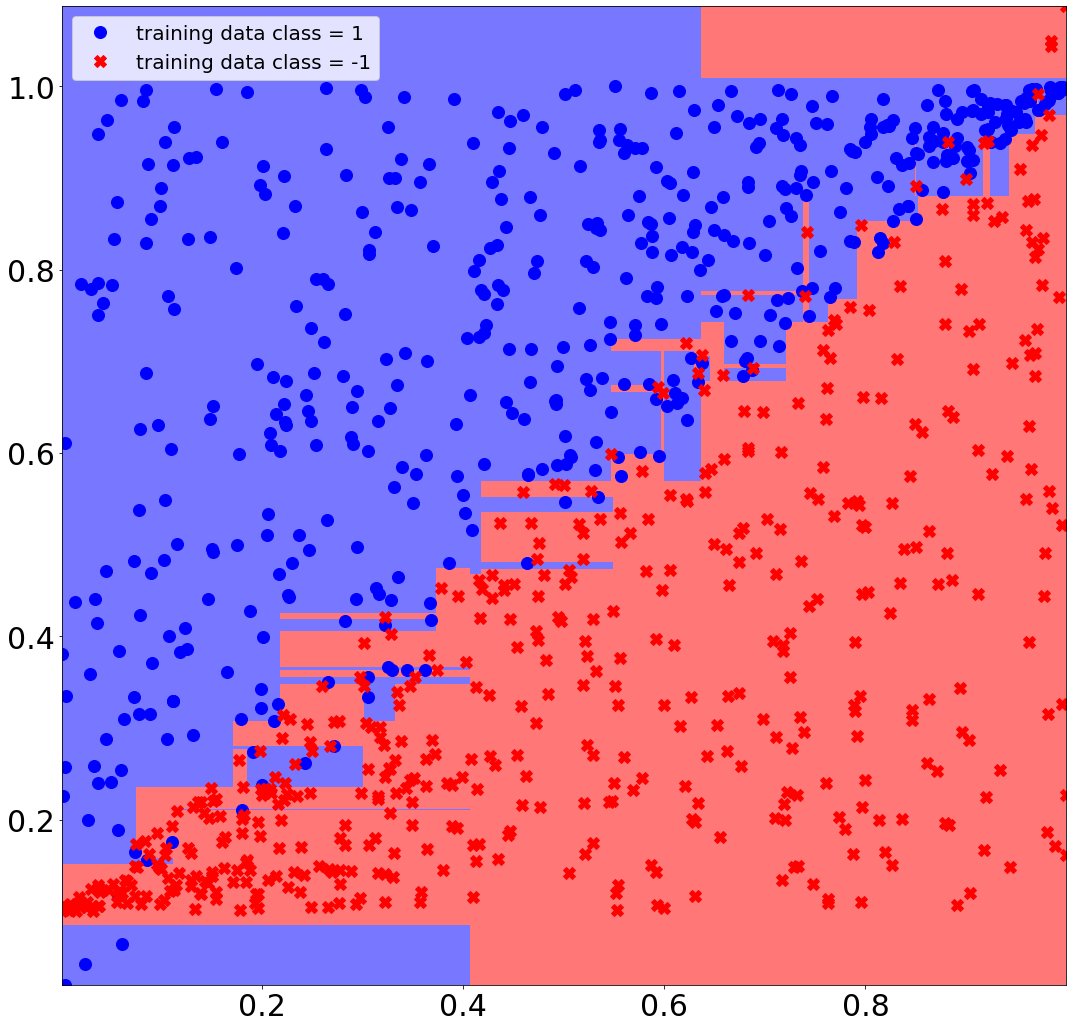

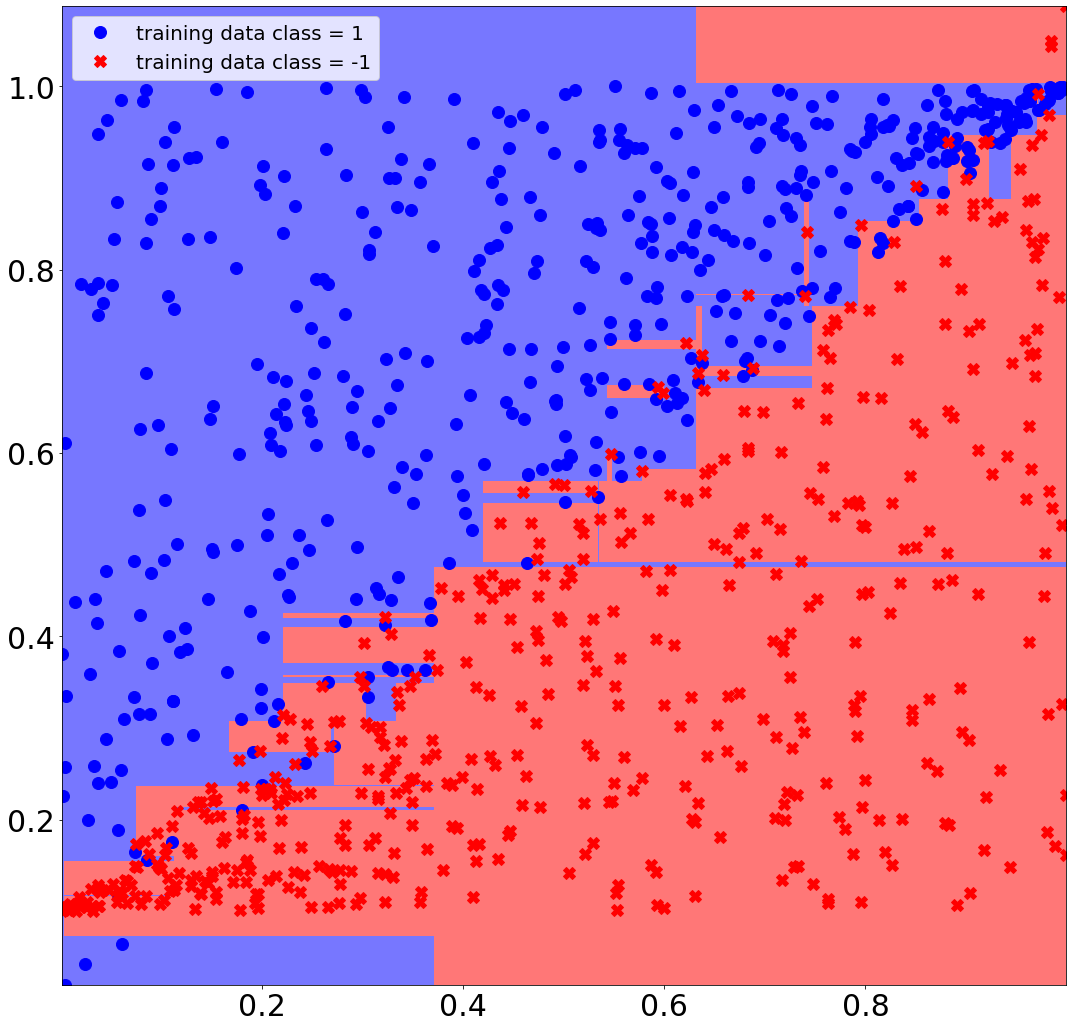

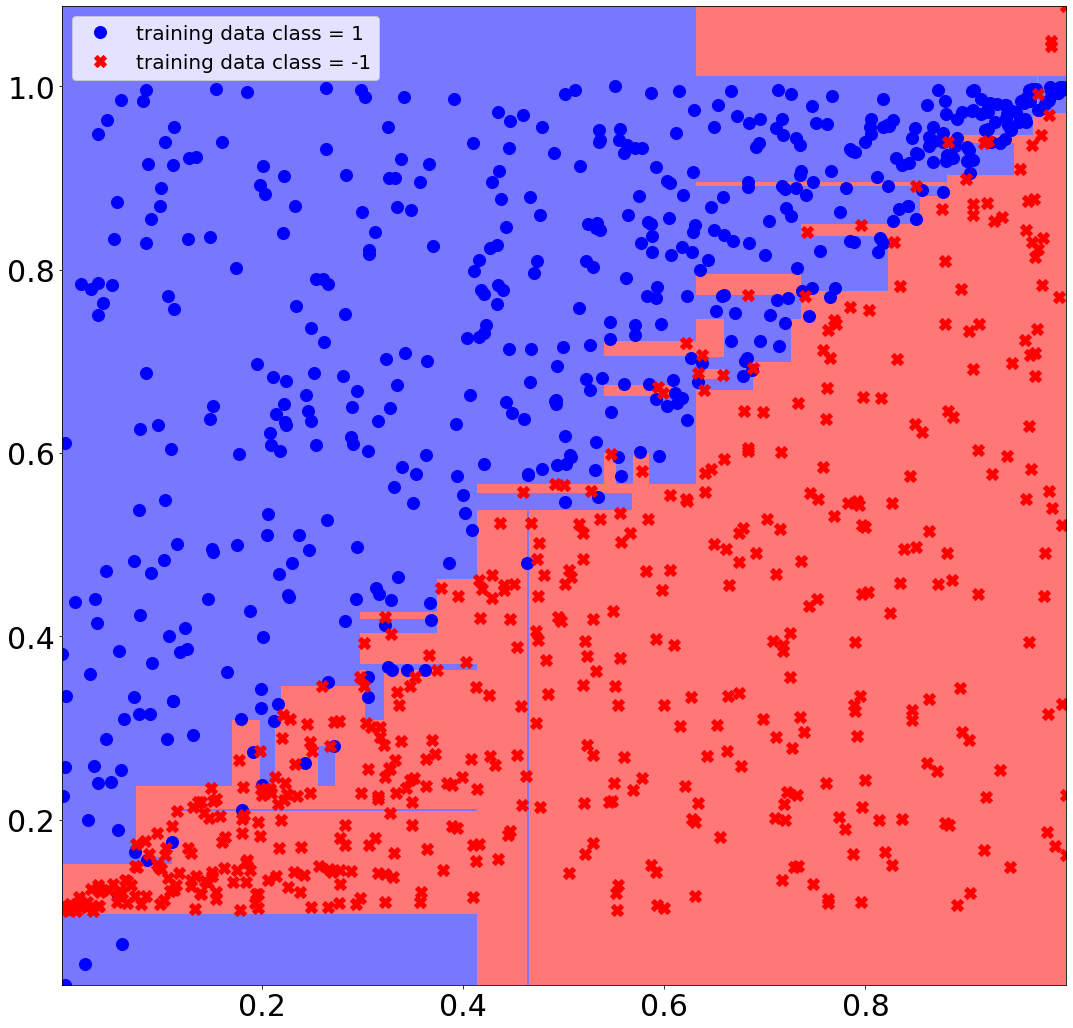

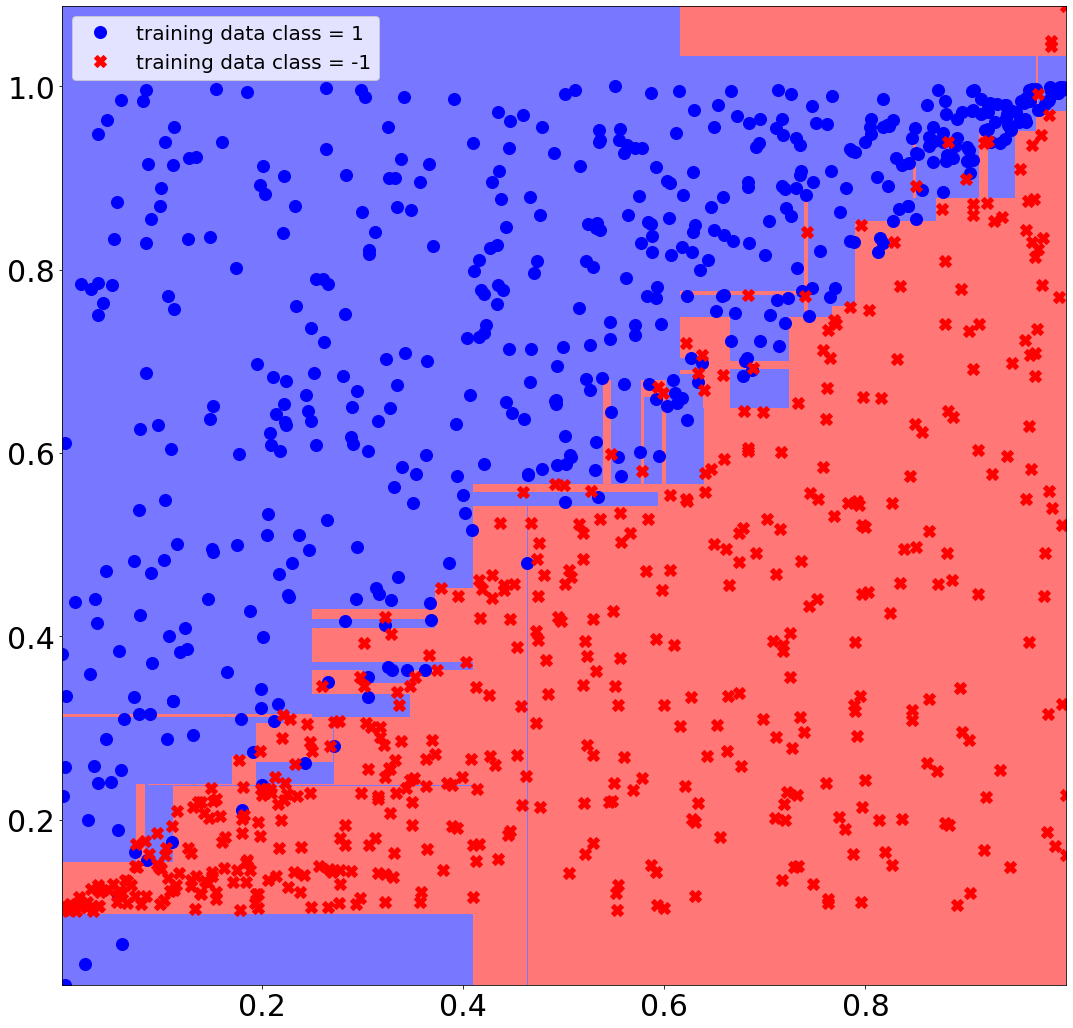

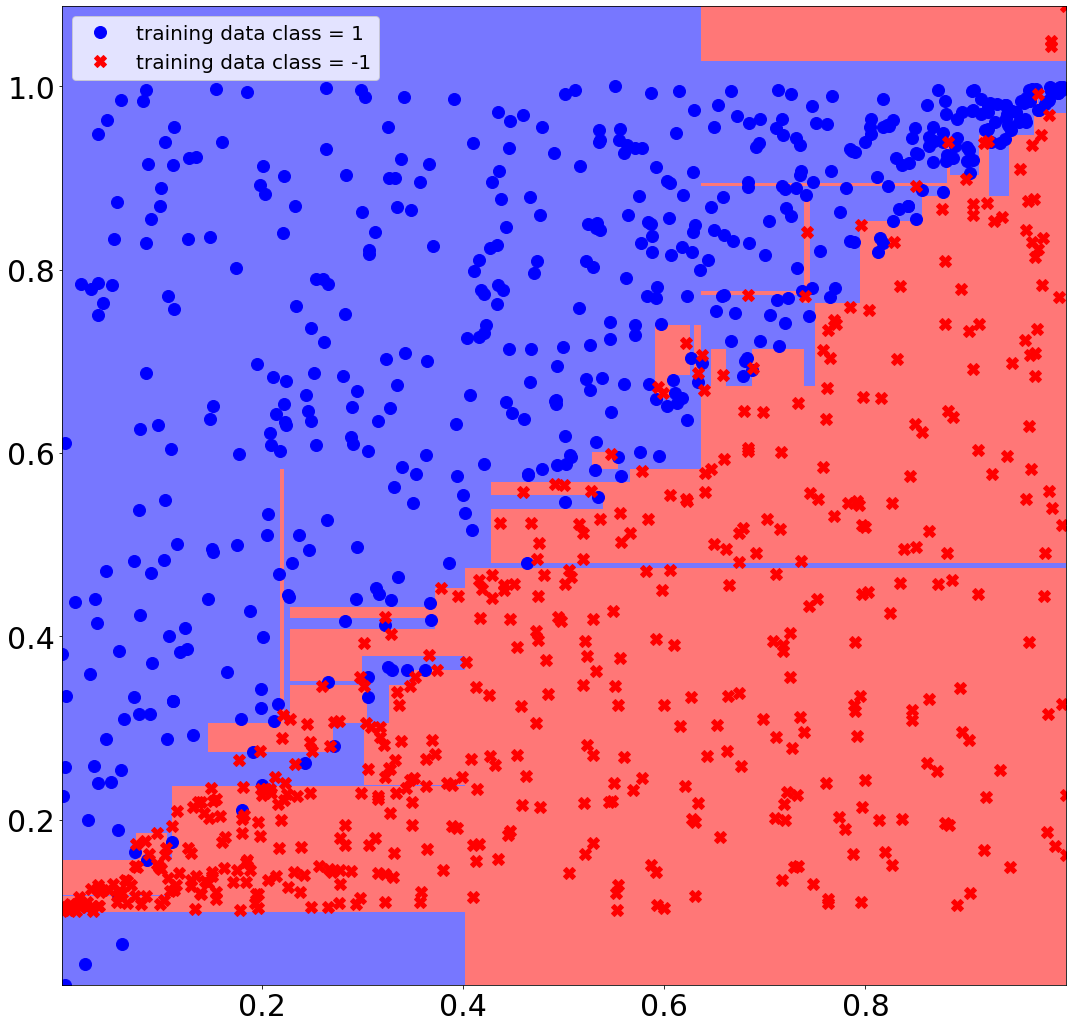

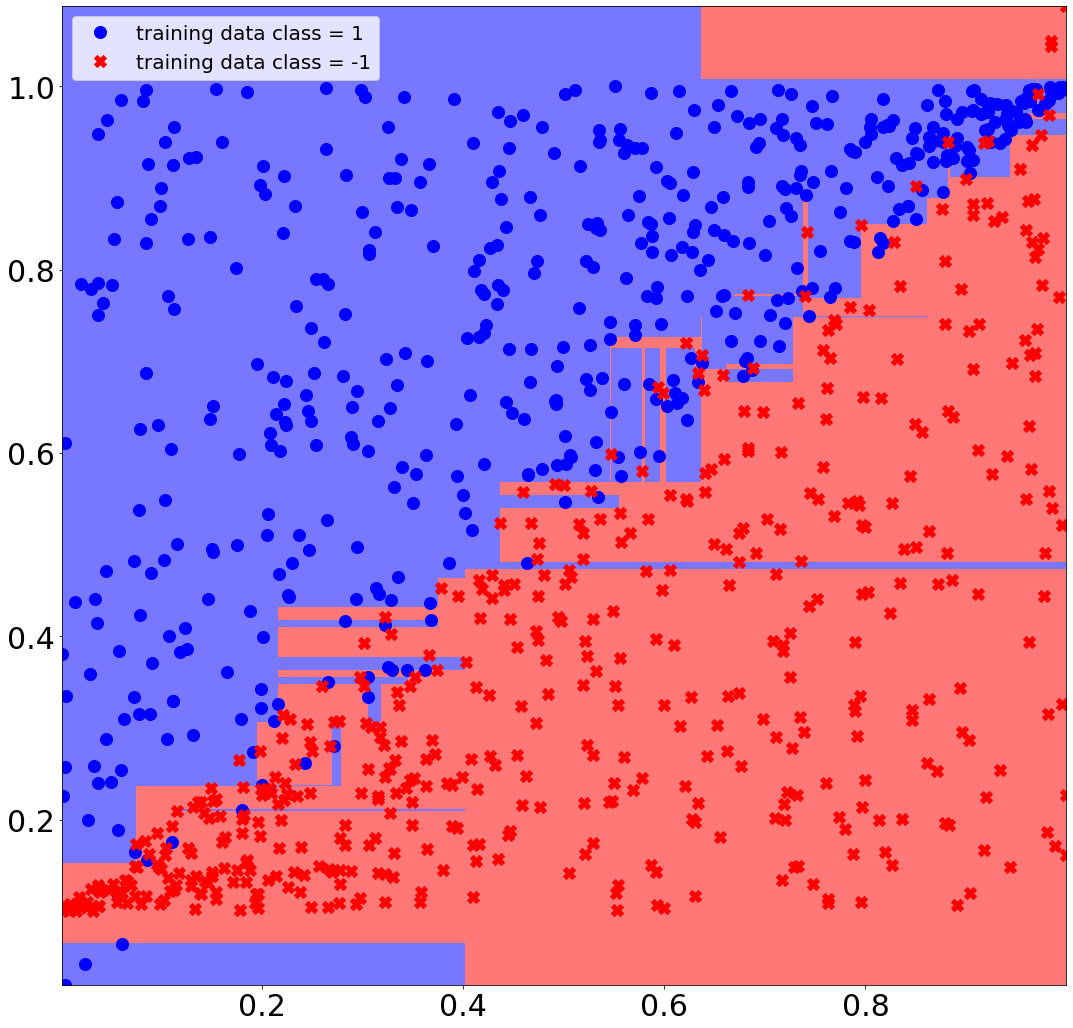

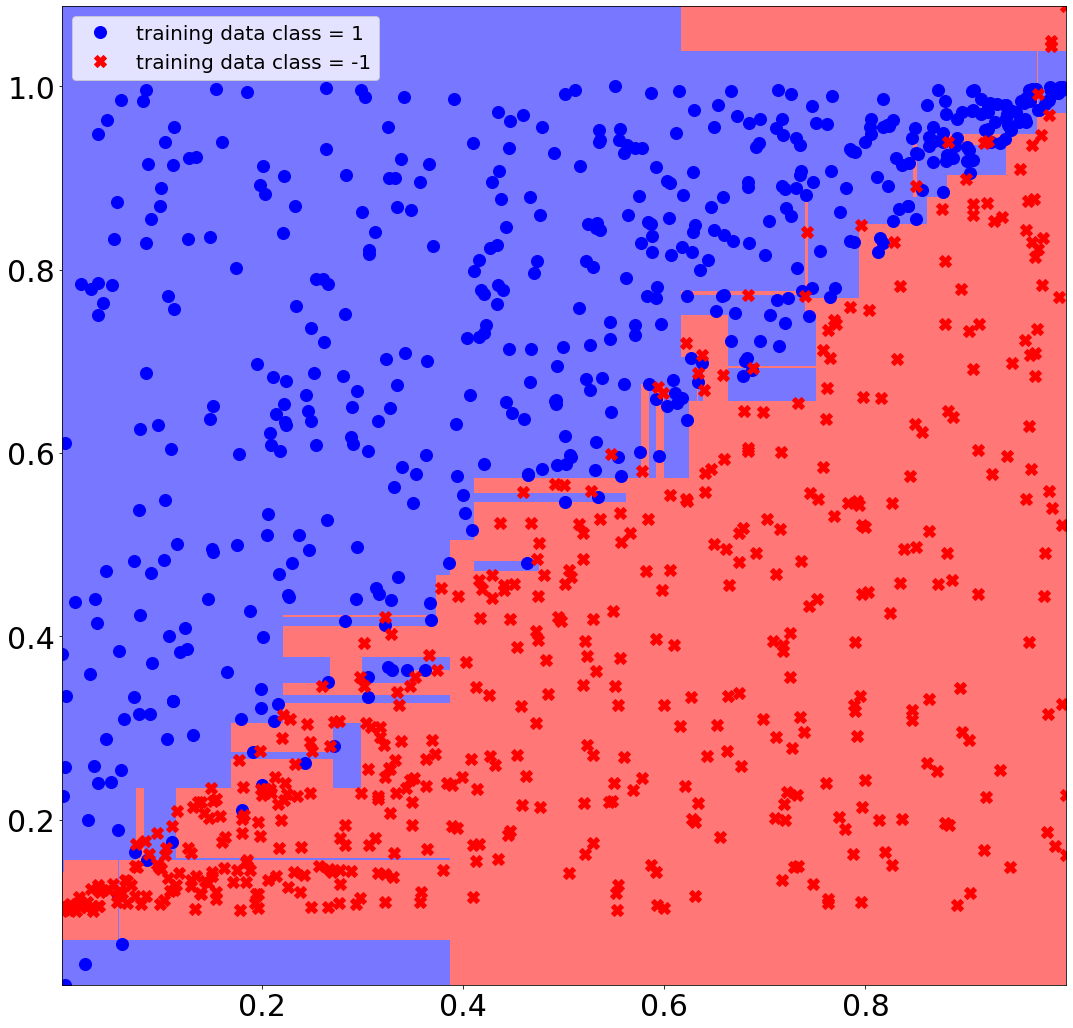

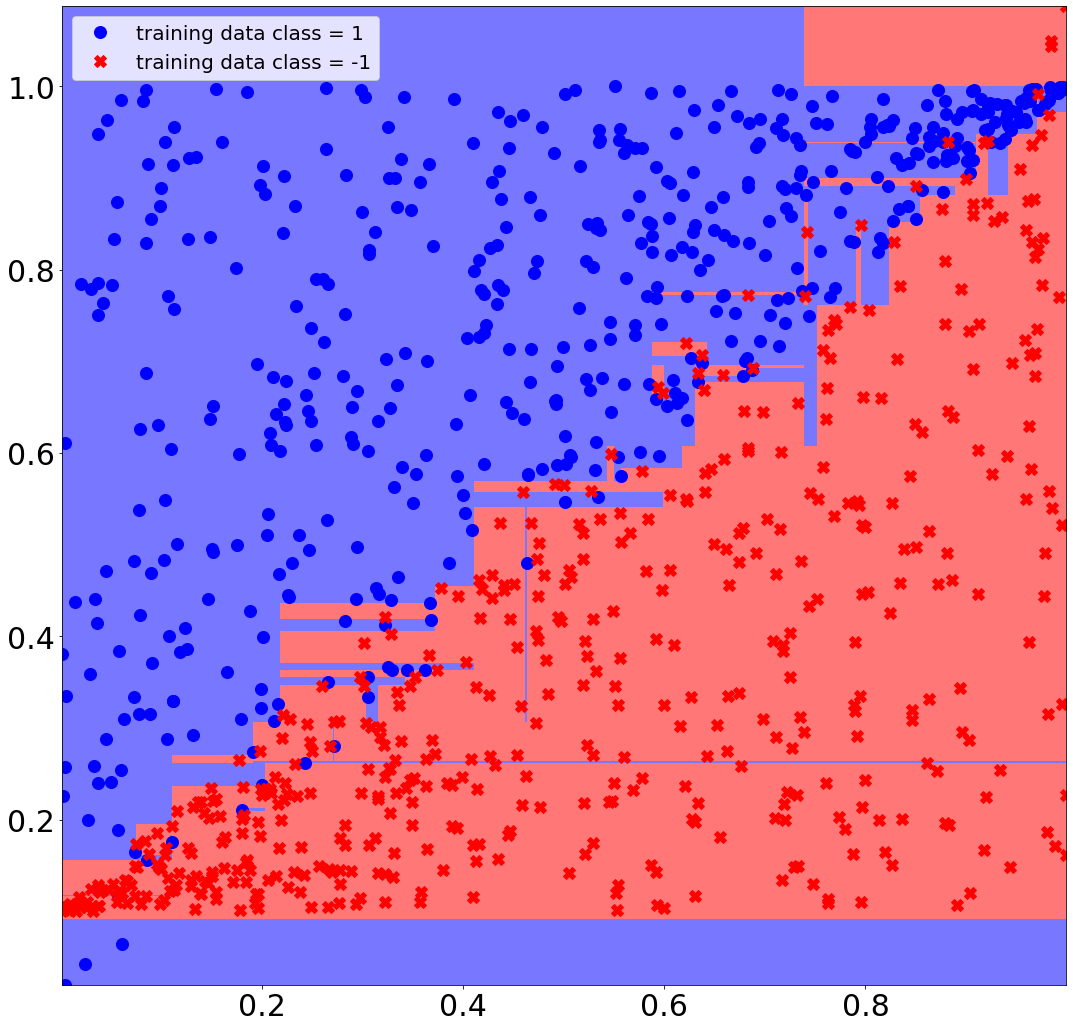

In [9]:
"""
Decision Tree
"""
x_lim=np.zeros((2,2))
x_lim[0,0],x_lim[0,1]=min(x[:,0]),max(x[:,0])
x_lim[1,0],x_lim[1,1]=min(x[:,1]),max(x[:,1])
y_train_DT=np.zeros(len(y))
y_pred_DT=np.zeros(len(y_test))
depth=10
fig = plt.figure()
ax = fig.add_subplot(111, xlim=(min(x[:,0]),max(x[:,0])), ylim=(min(x[:,1]),max(x[:,1])))
plt.rcParams["figure.figsize"] = (18,18)
y_train_DT,y_pred_DT=Decision_Tree(x,y,x,y,x_test,y_test,np.where(y),np.where(y_test),
                                   depth,x_lim,2,y_train_DT,y_pred_DT,0)
plt.plot(x[:500,0],x[:500,1],"bo",markersize=12,label="training data class = 1")
plt.plot(x[500:,0],x[500:,1],"rX",markersize=12,label="training data class = -1")
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=20)
plt.show()
print("==================================================================================")
"""
Random Forest
"""
start_time=time.time()
T=9
y_train_RF=np.zeros((len(y),T))
y_pred_RF=np.zeros((len(y_test),T))
for i in range(0,T):
    seed=choices(range(0,len(y)), k=len(y))
    fig = plt.figure()
    ax = fig.add_subplot(111, xlim=(min(x[:,0]),max(x[:,0])), ylim=(min(x[:,1]),max(x[:,1])))
    plt.rcParams["figure.figsize"] = (18,18)
    y_train_RF[:,i],y_pred_RF[:,i]=Decision_Tree(x[seed,:],y[seed],x,y,x_test,y_test,
                                                 np.where(y),np.where(y_test),
                                                 depth,x_lim,2,y_train_RF[:,i],y_pred_RF[:,i],0)
    plt.plot(x[:500,0],x[:500,1],"bo",markersize=12,label="training data class = 1")
    plt.plot(x[500:,0],x[500:,1],"rX",markersize=12,label="training data class = -1")
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(fontsize=20)
    plt.show()
end_time=time.time()
RF_time=end_time-start_time
print("==================================================================================")
"""
Extremely Randomized Trees
"""
start_time=time.time()
T=9
y_train_ET=np.zeros((len(y),T))
y_pred_ET=np.zeros((len(y_test),T))
for i in range(0,T):
    fig = plt.figure()
    ax = fig.add_subplot(111, xlim=(min(x[:,0]),max(x[:,0])), ylim=(min(x[:,1]),max(x[:,1])))
    plt.rcParams["figure.figsize"] = (18,18)
    y_train_ET[:,i],y_pred_ET[:,i]=Decision_Tree(x,y,x,y,x_test,y_test,
                                                 np.where(y),np.where(y_test),
                                                 depth,x_lim,2,y_train_ET[:,i],y_pred_ET[:,i],1)
    plt.plot(x[:500,0],x[:500,1],"bo",markersize=12,label="training data class = 1")
    plt.plot(x[500:,0],x[500:,1],"rX",markersize=12,label="training data class = -1")
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(fontsize=20)
    plt.show()
end_time=time.time()
ET_time=end_time-start_time

# Result

In [11]:
print("------------------------------------Decision Tree------------------------------------")
print("The Decision Tree Training error rate:",sum(~(y_train_DT==y))/len(y),
      " / Testing error rate:",sum(~(y_pred_DT==y_test))/len(y_test))
print("------------------------------------Random Forest------------------------------------")
for i in range(0,T):
    print("The",i+1, "iteration individual tree training error rate:",sum(~(y_train_RF[:,i]==y))/len(y),
    " / Testing error rate:",sum(~(y_pred_RF[:,i]==y_test))/len(y_test))
print("The Random Forest Training error rate:",
      sum(~(np.sign(np.sum(y_train_RF,axis=1))==y))/len(y),
      " / Testing error rate:",sum(~(np.sign(np.sum(y_pred_RF,axis=1))==y_test))/len(y_test),
      " / Execution Time =",RF_time)
print("------------------------------------Extremely Randomized Trees------------------------------------")
for i in range(0,T):
    print("The",i+1, "iteration individual tree training error rate:",sum(~(y_train_ET[:,i]==y))/len(y),
    " / Testing error rate:",sum(~(y_pred_ET[:,i]==y_test))/len(y_test))
print("The Extremely Randomized Trees Training error rate:",
      sum(~(np.sign(np.sum(y_train_ET,axis=1))==y))/len(y),
      " / Testing error rate:",sum(~(np.sign(np.sum(y_pred_ET,axis=1))==y_test))/len(y_test),
      " / Execution Time =",ET_time)

------------------------------------Decision Tree------------------------------------
The Decision Tree Training error rate: 0.025  / Testing error rate: 0.12
------------------------------------Random Forest------------------------------------
The 1 iteration individual tree training error rate: 0.042  / Testing error rate: 0.09
The 2 iteration individual tree training error rate: 0.042  / Testing error rate: 0.09
The 3 iteration individual tree training error rate: 0.047  / Testing error rate: 0.09
The 4 iteration individual tree training error rate: 0.036  / Testing error rate: 0.11
The 5 iteration individual tree training error rate: 0.032  / Testing error rate: 0.11
The 6 iteration individual tree training error rate: 0.037  / Testing error rate: 0.12
The 7 iteration individual tree training error rate: 0.038  / Testing error rate: 0.09
The 8 iteration individual tree training error rate: 0.031  / Testing error rate: 0.1
The 9 iteration individual tree training error rate: 0.042  